### 导入库

In [1]:
import torch
from torch.utils import data
import torchvision
from torchvision import transforms
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

from data import LoadData
from model import VGG16
from utils import *
from loss import EdgeHoldLoss

for name in (torch, torchvision, cv2, np):
    print(name.__version__)

1.6.0+cu101
0.7.0+cu101
4.3.0
1.19.1


### 使用GPU或者CPU

In [2]:
if torch.cuda.is_available():
    device = torch.device(device='cuda')
else:
    device = torch.device(device='cpu')
device

device(type='cuda')

In [3]:
path_image = "./DUTS/DUTS-TR/DUTS-TR-Image/"
path_mask = "./DUTS/DUTS-TR/DUTS-TR-Mask/"

In [4]:
batch_size = 4 #受限于贫穷，3是极限了
learning_rate = 0.000313
target_size = 256
epochs = 5

In [5]:
data_loader = data.DataLoader(LoadData(path_image, path_mask, target_size),
                            batch_size=batch_size,
                            shuffle=True)

In [6]:
total_batch = len(data_loader)
total_batch

2639

### 导入模型

In [7]:
model = VGG16()

In [8]:
model.load_state_dict(torch.load("./model/MPFA_25.pth"), strict=False)

<All keys matched successfully>

In [9]:
model.eval()
model.to(device)
criterion = EdgeHoldLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0, momentum=0.9)

In [10]:
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    
    total_loss = 0
    total_acc = 0
    total_pre = 0
    total_rec = 0
    total_f_score = 0
    
    for batch_n, (image, mask) in enumerate(data_loader, start=1):
        
        image = image.to(device)
        mask = mask.to(device)
        
        optimizer.zero_grad()
        predict = model(image)
        loss = criterion(predict, mask)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            total_loss += loss.item()
            acc = accuracy(predict, mask)
            total_acc += acc

            pre = precision(predict, mask)
            total_pre += pre

            rec = recall(predict, mask)
            total_rec += rec

            f_score = F_Measure(pre, rec)
            total_f_score += f_score
        
        
        if batch_n % 100 == 0:
            with torch.no_grad():
                avg_acc = total_acc / batch_n
                avg_pre = total_pre / batch_n
                avg_rec = total_rec / batch_n
                avg_f_score = total_f_score / batch_n
                print("Epoch:{} loss:{} Batch:{}/{}".format(epoch + 1, loss.item(), batch_n, total_batch), end="")
                print(" acc:{} pre:{} recall:{} F-measure:{}"
                      .format(avg_acc, avg_pre, avg_rec, avg_f_score))
    end_time = time.time()
    print("--------------------------------------------------------------")
    print("Epoch {} time:{:.2f}s END :loss:{} acc:{} pre:{} rec:{} F-measure:{}"
          .format(epoch + 1, 
                  end_time - start_time,
                  total_loss / total_batch, 
                  total_acc / total_batch,
                  total_pre / total_batch,
                  total_rec / total_batch,
                  total_f_score / total_batch))
    print("--------------------------------------------------------------")

Epoch:1 loss:0.38407135009765625 Batch:100/2639 acc:0.9239369034767151 pre:0.9323224425315857 recall:0.9015527963638306 F-measure:0.9233936667442322
Epoch:1 loss:0.37773266434669495 Batch:200/2639 acc:0.9253833293914795 pre:0.9323798418045044 recall:0.8971170783042908 F-measure:0.9222121238708496
Epoch:1 loss:0.3973037004470825 Batch:300/2639 acc:0.9250961542129517 pre:0.9321473240852356 recall:0.8938238620758057 F-measure:0.9212952852249146
Epoch:1 loss:0.38675808906555176 Batch:400/2639 acc:0.9249691367149353 pre:0.9336310625076294 recall:0.891490638256073 F-measure:0.9218407869338989
Epoch:1 loss:0.38307446241378784 Batch:500/2639 acc:0.9248356223106384 pre:0.9353732466697693 recall:0.8913998007774353 F-measure:0.9231501221656799
Epoch:1 loss:0.3849649429321289 Batch:600/2639 acc:0.9252464175224304 pre:0.9359024167060852 recall:0.893189013004303 F-measure:0.9239484071731567
Epoch:1 loss:0.38524046540260315 Batch:700/2639 acc:0.9247110486030579 pre:0.9366426467895508 recall:0.8933963

Epoch:3 loss:0.3868067264556885 Batch:100/2639 acc:0.9253957867622375 pre:0.9431291818618774 recall:0.903022289276123 F-measure:0.9320002794265747
Epoch:3 loss:0.3872723877429962 Batch:200/2639 acc:0.9246989488601685 pre:0.939064621925354 recall:0.8989974856376648 F-measure:0.9278587102890015
Epoch:3 loss:0.38331103324890137 Batch:300/2639 acc:0.9240909814834595 pre:0.9380574822425842 recall:0.898322343826294 F-measure:0.926702082157135
Epoch:3 loss:0.3804740905761719 Batch:400/2639 acc:0.9247597455978394 pre:0.938938319683075 recall:0.8996949791908264 F-measure:0.9279058575630188
Epoch:3 loss:0.3830852508544922 Batch:500/2639 acc:0.924377977848053 pre:0.9365693926811218 recall:0.8993367552757263 F-measure:0.925998330116272
Epoch:3 loss:0.3690848648548126 Batch:600/2639 acc:0.9247417449951172 pre:0.9379811882972717 recall:0.8982911109924316 F-measure:0.9268549680709839
Epoch:3 loss:0.3775705099105835 Batch:700/2639 acc:0.9245020151138306 pre:0.9382439851760864 recall:0.8972886204719543

Epoch:5 loss:0.3866512179374695 Batch:100/2639 acc:0.9235345125198364 pre:0.9341129064559937 recall:0.8959686756134033 F-measure:0.9234037399291992
Epoch:5 loss:0.38123124837875366 Batch:200/2639 acc:0.9211325645446777 pre:0.9363864064216614 recall:0.8956401348114014 F-measure:0.9249876737594604
Epoch:5 loss:0.3734264373779297 Batch:300/2639 acc:0.9236596822738647 pre:0.9368464350700378 recall:0.9003135561943054 F-measure:0.9264590740203857
Epoch:5 loss:0.37930193543434143 Batch:400/2639 acc:0.923385739326477 pre:0.9374937415122986 recall:0.8972020745277405 F-measure:0.9262645244598389
Epoch:5 loss:0.3720439076423645 Batch:500/2639 acc:0.9240026473999023 pre:0.9362953305244446 recall:0.8977621793746948 F-measure:0.9255451560020447
Epoch:5 loss:0.39452868700027466 Batch:600/2639 acc:0.9240090250968933 pre:0.9358237981796265 recall:0.8966651558876038 F-measure:0.9247516989707947
Epoch:5 loss:0.37441781163215637 Batch:700/2639 acc:0.9237470030784607 pre:0.9364089369773865 recall:0.8971173

In [11]:
torch.save(model.state_dict(),"./model/MPFA_30.pth")

In [12]:
def pad_resize_image(inp_img, out_img=None, target_size=None):
    h, w, c = inp_img.shape
    size = max(h, w)

    padding_h = (size - h) // 2
    padding_w = (size - w) // 2

    if out_img is None:
        # For inference
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x
    else:
        # For training and testing
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        temp_y = cv2.copyMakeBorder(out_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        # print(inp_img.shape, temp_x.shape, out_img.shape, temp_y.shape)

        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
            temp_y = cv2.resize(temp_y, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x, temp_y


In [13]:
def getInput(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32')
    
    img = pad_resize_image(img, target_size=256)
    img /= 255.
    img = np.transpose(img, axes=(2, 0, 1))
    img = torch.from_numpy(img).float()
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]) 
    
    img = normalize(img)
    return img

In [14]:
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

In [15]:
msk.shape

torch.Size([256, 256, 1])

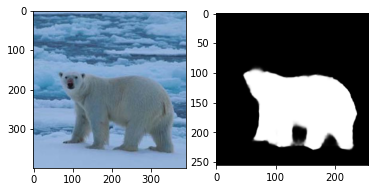

In [16]:
img = getInput("./image/1.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()

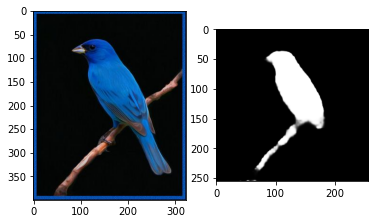

In [17]:
img = getInput("./image/2.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()

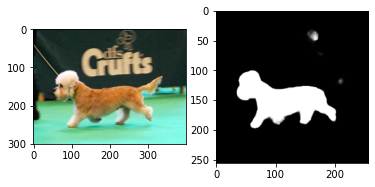

In [18]:
img = getInput("./image/3.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/3.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()